# RNN Time Series Prediction

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim

In [ ]:
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

## Data

### Fictitious Time Series

Let's define the length of the sequence of values used for training:

In [ ]:
# Sequence length
len_sequence = 25

We will try to predict the values of a `sin` wave. Let's create on sequence as a `sin` time series:

In [ ]:
# Fictitious time series
time = np.linspace(0, np.pi, len_sequence + 1)
data = np.sin(time)

# Reshape data to add input size dimension
# Shape of data is now (len_sqeuence + 1, s_input)
data = data.reshape(-1, 1)

assert data.shape == (len_sequence + 1, 1)

We can then define an the input sequence as the data from `0` to `len_sequence` and the target sequence as the data from `1` to `len_sequence + 1`. The RNN will then be trained to predict a sequence that is shfted in time by one time unit `dt = time[1] - time[0]`.

In [ ]:
input = data[:-1]
target = data[1:]

Let's plot our fictitious time series:

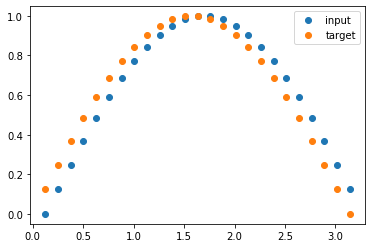

In [ ]:
plt.figure()
plt.plot(time[1:], input, "o", label="input")
plt.plot(time[1:], target, "o", label="target")
plt.legend()
plt.show()

We see that the `target` sequence corresponds to the `input` sequence shifted in time.

## RNN

### Definition

We can now define a RNN. A RNN is composed of an input layer, one of multiple hidden layers and an output layer. In addition, it outputs a hidden state that encodes the previous history of the network (memory). In the forward function we propagate the input and previous hidden state trough a RNN and get an output and the new hidden state of the RNN. The output is finally passed trough a fully connected layer to obtain the final predictions.

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, 
                 s_input, # Number of input features
                 s_output, # Number of outpus
                 s_hidden, # Number of features in the hidden layer
                 n_layers, # Number or RNN layer stacked
            ):
        
        super().__init__()
        
        self.s_input = s_input
        self.s_hidden = s_hidden
        self.s_output = s_output

        # RNN layer
        # Shape (batch, sequence, feature)
        self.rnn = nn.RNN(s_input, s_hidden, n_layers, batch_first=True)
        
        # Fully connected layer for output
        self.fc = nn.Linear(s_hidden, s_output)
        
    def forward(self, x, hidden):
        
        # Batch size, sequence length and input size
        batch_size, len_sequence, s_input = x.shape
                
        assert s_input == self.s_input
        
        # RNN forward pass
        # Get RNN output and new RNN hidden state
        output, hidden = self.rnn(x, hidden)
        
        assert output.shape == (batch_size, len_sequence, self.s_hidden)
        
        # Reshape output as(batch_size * len_sequence, s_hidden)
        output = output.view(-1, self.s_hidden)
        
        assert output.shape == (batch_size * len_sequence, self.s_hidden)
        
        # Compute output
        output = self.fc(output)
        
        assert output.shape == (batch_size * len_sequence, self.s_output)
        
        return output, hidden

### Test

As usual, let's test the forward pass. The number of input features is `1` (only one response variable for time) and the number of output features is also `1` (the same response variable shifted in time of one time step). The number of hidden units and the number of RNN layers are hyperparameters of the model.

In [ ]:
# Define a RNN model
rnntest = RNN(s_input=1, s_output=1, s_hidden=15, n_layers=2)

# Define RNN input
# Add first batch dimension
inputtest = torch.Tensor(data[:-1]).unsqueeze(0)

# RNN propagation starting with `hidden=None`
output, hidden = rnntest(inputtest, None)

print(f"Input size: {inputtest.size()}")
print(f"Hidden size: {hidden.size()}")
print(f"Output size: {output.size()}")

Input size: torch.Size([1, 25, 1])
Hidden size: torch.Size([2, 1, 15])
Output size: torch.Size([25, 1])


## Training 

Let's define a RNN architecture:

In [ ]:
s_hidden = 20 # Number of hidden units
n_layers = 1 # Number of RNN layers

rnn = RNN(s_input=1, s_output=1, s_hidden=s_hidden, n_layers=n_layers)

The loss between the RNN output and the target sequence (output sequence shifted in time) is computed with the mean square error:

In [ ]:
loss_function = nn.MSELoss()

Finally we can define an optimizer an link it to the model parameters:

In [ ]:
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

In the training loop we define the training data on the fly by shifting the time on intervals $[n \pi, (n+1)\pi]$ where $n$ is the epoch index. The input is propagated through the RNN together with the previous hidden state, the loss is computed and the parameters of the RNN are adjusted consequently. The  hidden state is detached from the computational graph at every step to avoid backpropagation through the entire history. 

In [ ]:
def train(model, epochs, print_every=25):
    """
    Train RNN model for a given number of epochs.
    """
    
    # Initial hidden state
    hidden = None
    
    for epoch in range(epochs):
        # Training data (produced on the fly)
        time = np.linspace(epoch * np.pi, (epoch + 1) * np.pi, len_sequence + 1)
        data = np.sin(time).reshape(-1, 1)
        
        # Split data in input and target
        # Target is the input shifted in time of one time step
        input = torch.Tensor(data[:-1]).unsqueeze(0)
        target = torch.Tensor(data[1:])
        
        # RNN propagation using previous hidden state
        output, hidden = rnn(input, hidden)
        
        # Detach the hidden state from the computational graph
        # Avoid backpropagation through the entire history
        hidden = hidden.detach()
        
        # Compute the loss
        loss = loss_function(output, target)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print loss 
        if epoch % print_every == 0:        
            print(f"Loss: {loss.item():.5}")
            plt.figure()
            plt.plot(time[1:], input.clone().detach().numpy().squeeze(), "o", label="input")
            plt.plot(time[1:], output.clone().detach().numpy().squeeze(), "o", label="output")
            plt.plot(time[1:], target.clone().detach().numpy().squeeze(), ".", label="target")
            plt.legend()
            plt.show()

Loss: 1.2414


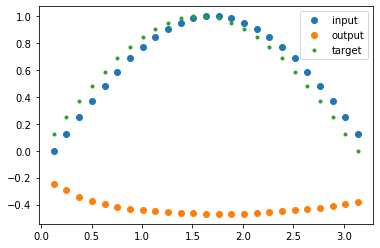

Loss: 0.033617


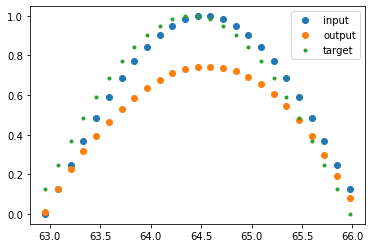

Loss: 0.0037728


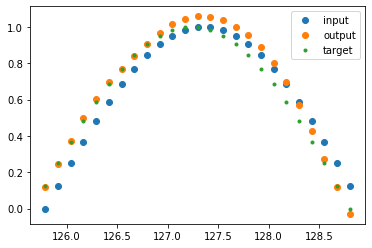

Loss: 0.00070358


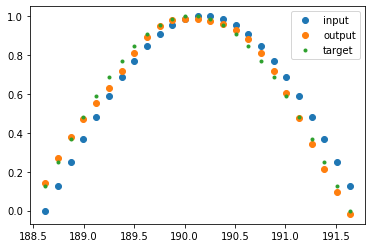

Loss: 0.00087734


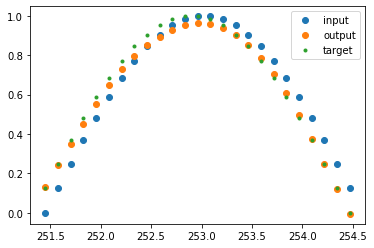

In [ ]:
epochs = 100

train(rnn, epochs, 20)

We see that as the training progresses, the output of the RNN looks more and more as the target.

## Predictions

In order to perform predictions we start with data from the last reaining epoch and a `None` hidden state. After obtaining a sequence of predictions from the RNN, we extract the last element of the prediciton vector which is the new data point we are interested in. Then we create the input for the next iteration by shifting the old input backward in time (discarding the oldest data point) and append the new prediction. We repeat this process for as many predictions as needed:

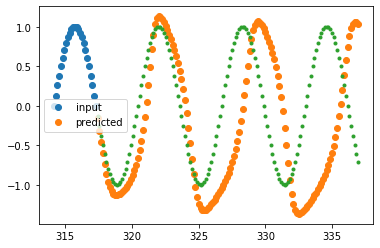

In [ ]:
n_predictions = 150

predictions = []

# First input data (last known sequence used for training)
time = np.linspace(epochs * np.pi, (epochs + 1) * np.pi, len_sequence)
data = np.sin(time).reshape(-1, 1)

hidden = None
input = torch.Tensor(data).unsqueeze(0)

for _ in range(n_predictions):
    
    with torch.no_grad():
        
        prediction, hidden = rnn(input, hidden)
        
        # Detach hidden state from computational graph
        hidden = hidden.detach()
        
        # Extract new prediction
        new = prediction[-1].clone().detach().item()
    
        # Shift input data, discarding oldest value
        # Shape of input is (batch, sequence, feature)
        input[:,:-1,:] = input[:,1:,:].clone().detach()
        
        # Append new prediction to input
        input[:,-1,:] = new
    
        # Append prediction to list of predictions
        predictions.append(new)
    

# Compute time of predictions (outside of training)
dt = time[1] - time[0]
start = (epochs + 1) * np.pi + dt
stop = (epochs + 1) * np.pi + dt * (n_predictions + 1)
timelater = np.arange(start, stop, dt)
    
# Plot predictions
plt.figure()
plt.plot(time, data, "o", label="input")
plt.plot(timelater, predictions, "o", label="predicted")
plt.plot(timelater, np.sin(timelater), ".", label="")
plt.legend()
plt.show()

We see that after a while the predictions go out-of-phase with respect to the exact solution. We won't get rich by predicting the behaviour of the stock marcket any time soon.